# Analisis Exploratorio de todos los Datos de BBVA

In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as kt
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from bioinfokit.visuz import cluster
from datetime import date
from sklearn import linear_model
import requests
import math

In [74]:
dataset = pd.read_excel("Datasets/dataset_tasacion_train.xlsx", header=[0], index_col=None)
#Pequeño truquito para tratar los datos NA como ceros
dataset = dataset.fillna(0)

dataset.head()

#Son 39,619 datos
#print(len(dataset))

,Fecha entrega del Informe,Calle,Piso,Departamento,Provincia,Distrito,Número de estacionamiento,Depósitos,Latitud (Decimal),Longitud (Decimal),...,Posición,Número de frentes,Edad,Elevador,Estado de conservación,Método Representado,Moneda principal para cálculos,Área Terreno,Área Construcción,Valor comercial
0,2016-09-01 19:00:00,REBECA OQUENDO,0,Lima,Lima,Breña,1.0,0.0,-12.059545,-77.046595,...,0,0.0,4.0,0.0,0,Comparación de mercado (directo),0,15.91,65.30,83754
1,2021-03-11 19:00:00,CONDOMINIO DOSS,0,Lima,Lima,Comas,0.0,0.0,-11.937662,-77.066525,...,0,0.0,0.0,0.0,En proyecto,Comparación de mercado (directo),0,8.12,91.78,85355
2,2019-03-18 19:00:00,MANZANA 14 LT 10 LOS JARDINES DEL GOLF,0,La Libertad,Trujillo,Victor Larco Herrera,0.0,0.0,-8.135306,-79.035518,...,0,0.0,12.0,0.0,Regular,Comparación de mercado (directo),0,20.51,89.19,83838
3,2019-07-25 19:00:00,TRINIDAD MORAN,0,Lima,Lima,Lince,0.0,0.0,-12.089796,-77.039245,...,0,0.0,0.0,0.0,En proyecto,Comparación de mercado (directo),0,7.48,52.90,111619
4,2018-01-01 19:00:00,MZ 8 AC,0,Lima,Lima,Villa María del Triunfo,1.0,0.0,-12.181048,-76.927642,...,0,0.0,19.0,0.0,Bueno,Costos o reposición (directo),0,240.00,566.00,305191


In [54]:

all_headers = ['Fecha entrega del Informe', 
               'Calle', 
               'Piso', 
               'Departamento',
               'Provincia', 
               'Distrito', 
               'Número de estacionamiento',
               'Depósitos',
               'Latitud (Decimal)', 
               'Longitud (Decimal)', 
               'Categoría del bien',
               'Posición', 
               'Número de frentes', 
               'Edad', 
               'Elevador',
               'Estado de conservación', 
               'Método Representado', 
               'Área Terreno',
               'Área Construcción', 
               'Valor comercial (USD)']


In [55]:
non_numerical = ['Fecha de entrega del Informe',
                 'Calle',
                 'Piso',
                 'Departamento',
                 'Provincia',
                 'Distrito',
                 'Categoría del bien',
                 'Posición',
                 'Estado de conservación',
                 'Método Representado']

numerical = ['Número de estacionamiento',
             'Depósitos',
             'Latitud (Decimal)',
             'Longitud (Decimal)',
             'Número de frentes',
             'Edad',
             'Elevador',
             'Área Terreno',
             'Área Construcción',
             'Valor comercial (USD)']

categorical = ['Departamento',
               'Provincia', 
               'Distrito',  
               'Categoría del bien',
               'Posición',   
               'Método Representado']

continuous = ['Latitud (Decimal)', 
              'Longitud (Decimal)', 
              'Área Terreno',
              'Área Construcción', 
              'Valor comercial (USD)']

discrete = ['Número de estacionamiento',
            'Depósitos',
            'Número de frentes', 
            'Edad', 
            'Elevador']

numerical_non_categorical = ['Número de estacionamiento',
                              'Depósitos',
                              'Latitud (Decimal)',
                              'Longitud (Decimal)',
                              'Número de frentes',
                              'Edad',
                              'Elevador',
                              'Área Terreno',
                              'Área Construcción',
                              'Valor comercial']

geographicals = ['Calle',
                 'Departamento',
                 'Provincia',
                 'Distrito',
                 'Latitud (Decimal)',
                 'Longitud (Decimal)']


In [56]:
departamentos = ['Amazonas',
                 'Ancash',
                 'Apurimac', 
                 'Arequipa', 
                 'Ayacucho', 
                 'Cajamarca', 
                 'Callao', 
                 'Cusco',
                 'Huancavelica', 
                 'Huanuco', 
                 'Ica', 
                 'Junín', 
                 'La Libertad', 
                 'Lambayeque', 
                 'Lima', 
                 'Loreto', 
                 'Madre de Dios', 
                 'Moquegua', 
                 'Pasco', 
                 'Piura', 
                 'Puno', 
                 'San Martín', 
                 'Tacna', 
                 'Tumbes', 
                 'Ucayali']

In [57]:
#Idealmente este paso lo tendría que volver a hacer, ya que necesito volver a generar las matrices, 
#de correlaciones de cada uno de los departamentos.

#A <- Heavy age
#B <- Square symetry
#C <- Abnormal

#Grupos por departamento

grupos = {'A' : ['Arequipa', 'Huancavelica', 'Junín', 'Lima', 'Monquegua', 'Piura', 'San Martín'],
          'B' : ['Ayacucho', 'Callao', 'Cusco', 'La Libertad', 'Lambayeque', 'Loreto', 'Pasco', 'Puno', 'Tacna', 'Tumbes', 'Ucayali'],
          'C' : ['Amazonas', 'Madre de Dios']}

In [58]:
numerical_data = dataset[numerical_non_categorical].copy()

numerical_data['Latitud (Decimal)'] = (numerical_data['Latitud (Decimal)'] - numerical_data['Latitud (Decimal)'].min()) / (numerical_data['Latitud (Decimal)'].max() - numerical_data['Latitud (Decimal)'].min())
numerical_data['Longitud (Decimal)'] = (numerical_data['Longitud (Decimal)'] - numerical_data['Longitud (Decimal)'].min()) / (numerical_data['Longitud (Decimal)'].max() - numerical_data['Longitud (Decimal)'].min())

#numerical_data['Número de estacionamiento'].replace(np.nan, 0.0, inplace=True)


numerical_data = numerical_data.applymap(lambda x : float(x.replace(',','')) if isinstance(x,str) else x)
numerical_data_log = numerical_data.applymap(lambda x : np.log10(x + 0.00001))
numerical_data_log = numerical_data_log.fillna(0)

In [59]:
numerical_data_log.head()

,Número de estacionamiento,Depósitos,Latitud (Decimal),Longitud (Decimal),Número de frentes,Edad,Elevador,Área Terreno,Área Construcción,Valor comercial
0,0.000004,-5.0,-0.005229,-1.657866,0.0,0.602061,0.0,1.201670,1.814913,4.923006
1,-5.000000,-5.0,-0.005229,-1.659919,0.0,-5.000000,0.0,0.909557,1.962748,4.931229
2,-5.000000,-5.0,-0.005227,-1.934008,0.0,1.079182,0.0,1.311966,1.950316,4.923441
3,0.000000,0.0,-0.005229,-1.657112,0.0,-5.000000,0.0,0.873902,1.723456,5.047738
4,0.000004,-5.0,-0.005229,-1.645814,0.0,1.278754,0.0,2.380211,2.752816,5.484572


In [60]:
numerical_data.describe()

,Número de estacionamiento,Depósitos,Latitud (Decimal),Longitud (Decimal),Número de frentes,Edad,Elevador,Área Terreno,Área Construcción,Valor comercial
count,30923.000000,28553.000000,39613.000000,39610.000000,2964.000000,39195.000000,4395.000000,3.736900e+04,39299.000000,3.961900e+04
mean,0.699382,0.230519,0.987998,0.024740,0.587719,14.407450,1.255745,2.942877e+02,161.553201,2.272190e+05
std,19.836872,2.690935,0.004965,0.029389,0.845906,31.962071,0.777550,1.340630e+04,152.641955,3.136169e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000e+00
25%,0.000000,0.000000,0.988022,0.021902,0.000000,1.000000,1.000000,1.297000e+01,78.820000,9.726800e+04
50%,0.000000,0.000000,0.988022,0.022101,0.000000,6.000000,1.000000,3.219000e+01,113.160000,1.531660e+05
75%,1.000000,0.000000,0.988022,0.022359,1.000000,21.000000,2.000000,1.390000e+02,195.870000,2.628320e+05
max,2424.000000,200.000000,1.000000,1.000000,22.000000,2022.000000,11.000000,1.800000e+06,9510.000000,2.444672e+07


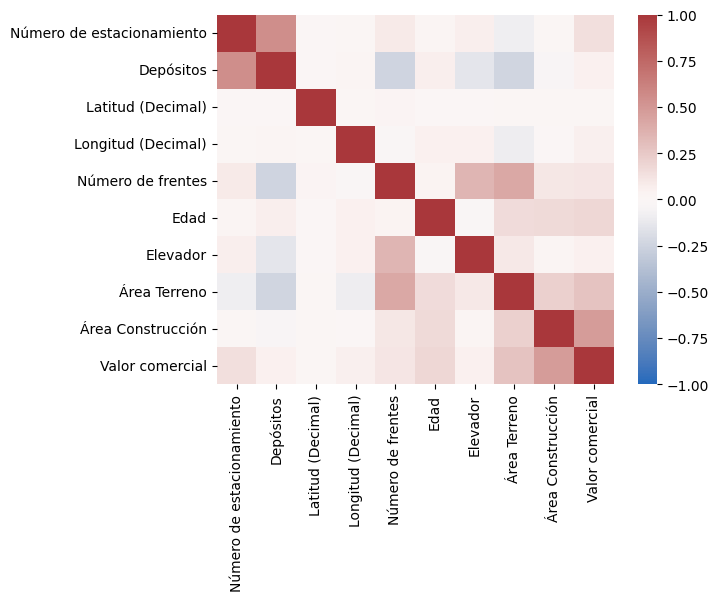

In [61]:
sns.heatmap(numerical_data_log.corr(), cmap='vlag', vmin=-1, vmax=1)
plt.show()

In [75]:
pca_out = PCA().fit(numerical_data_log)
pca_scores = PCA().fit_transform(numerical_data_log)
loadings = pca_out.components_

cluster.biplot(cscore=pca_scores, loadings=loadings, labels=numerical_data_log.columns.values, 
               var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2))

cluster.biplot(cscore=pca_scores, loadings=loadings, labels=numerical_data_log.columns.values, 
               var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
               var3=round(pca_out.explained_variance_ratio_[2]*100, 2))

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

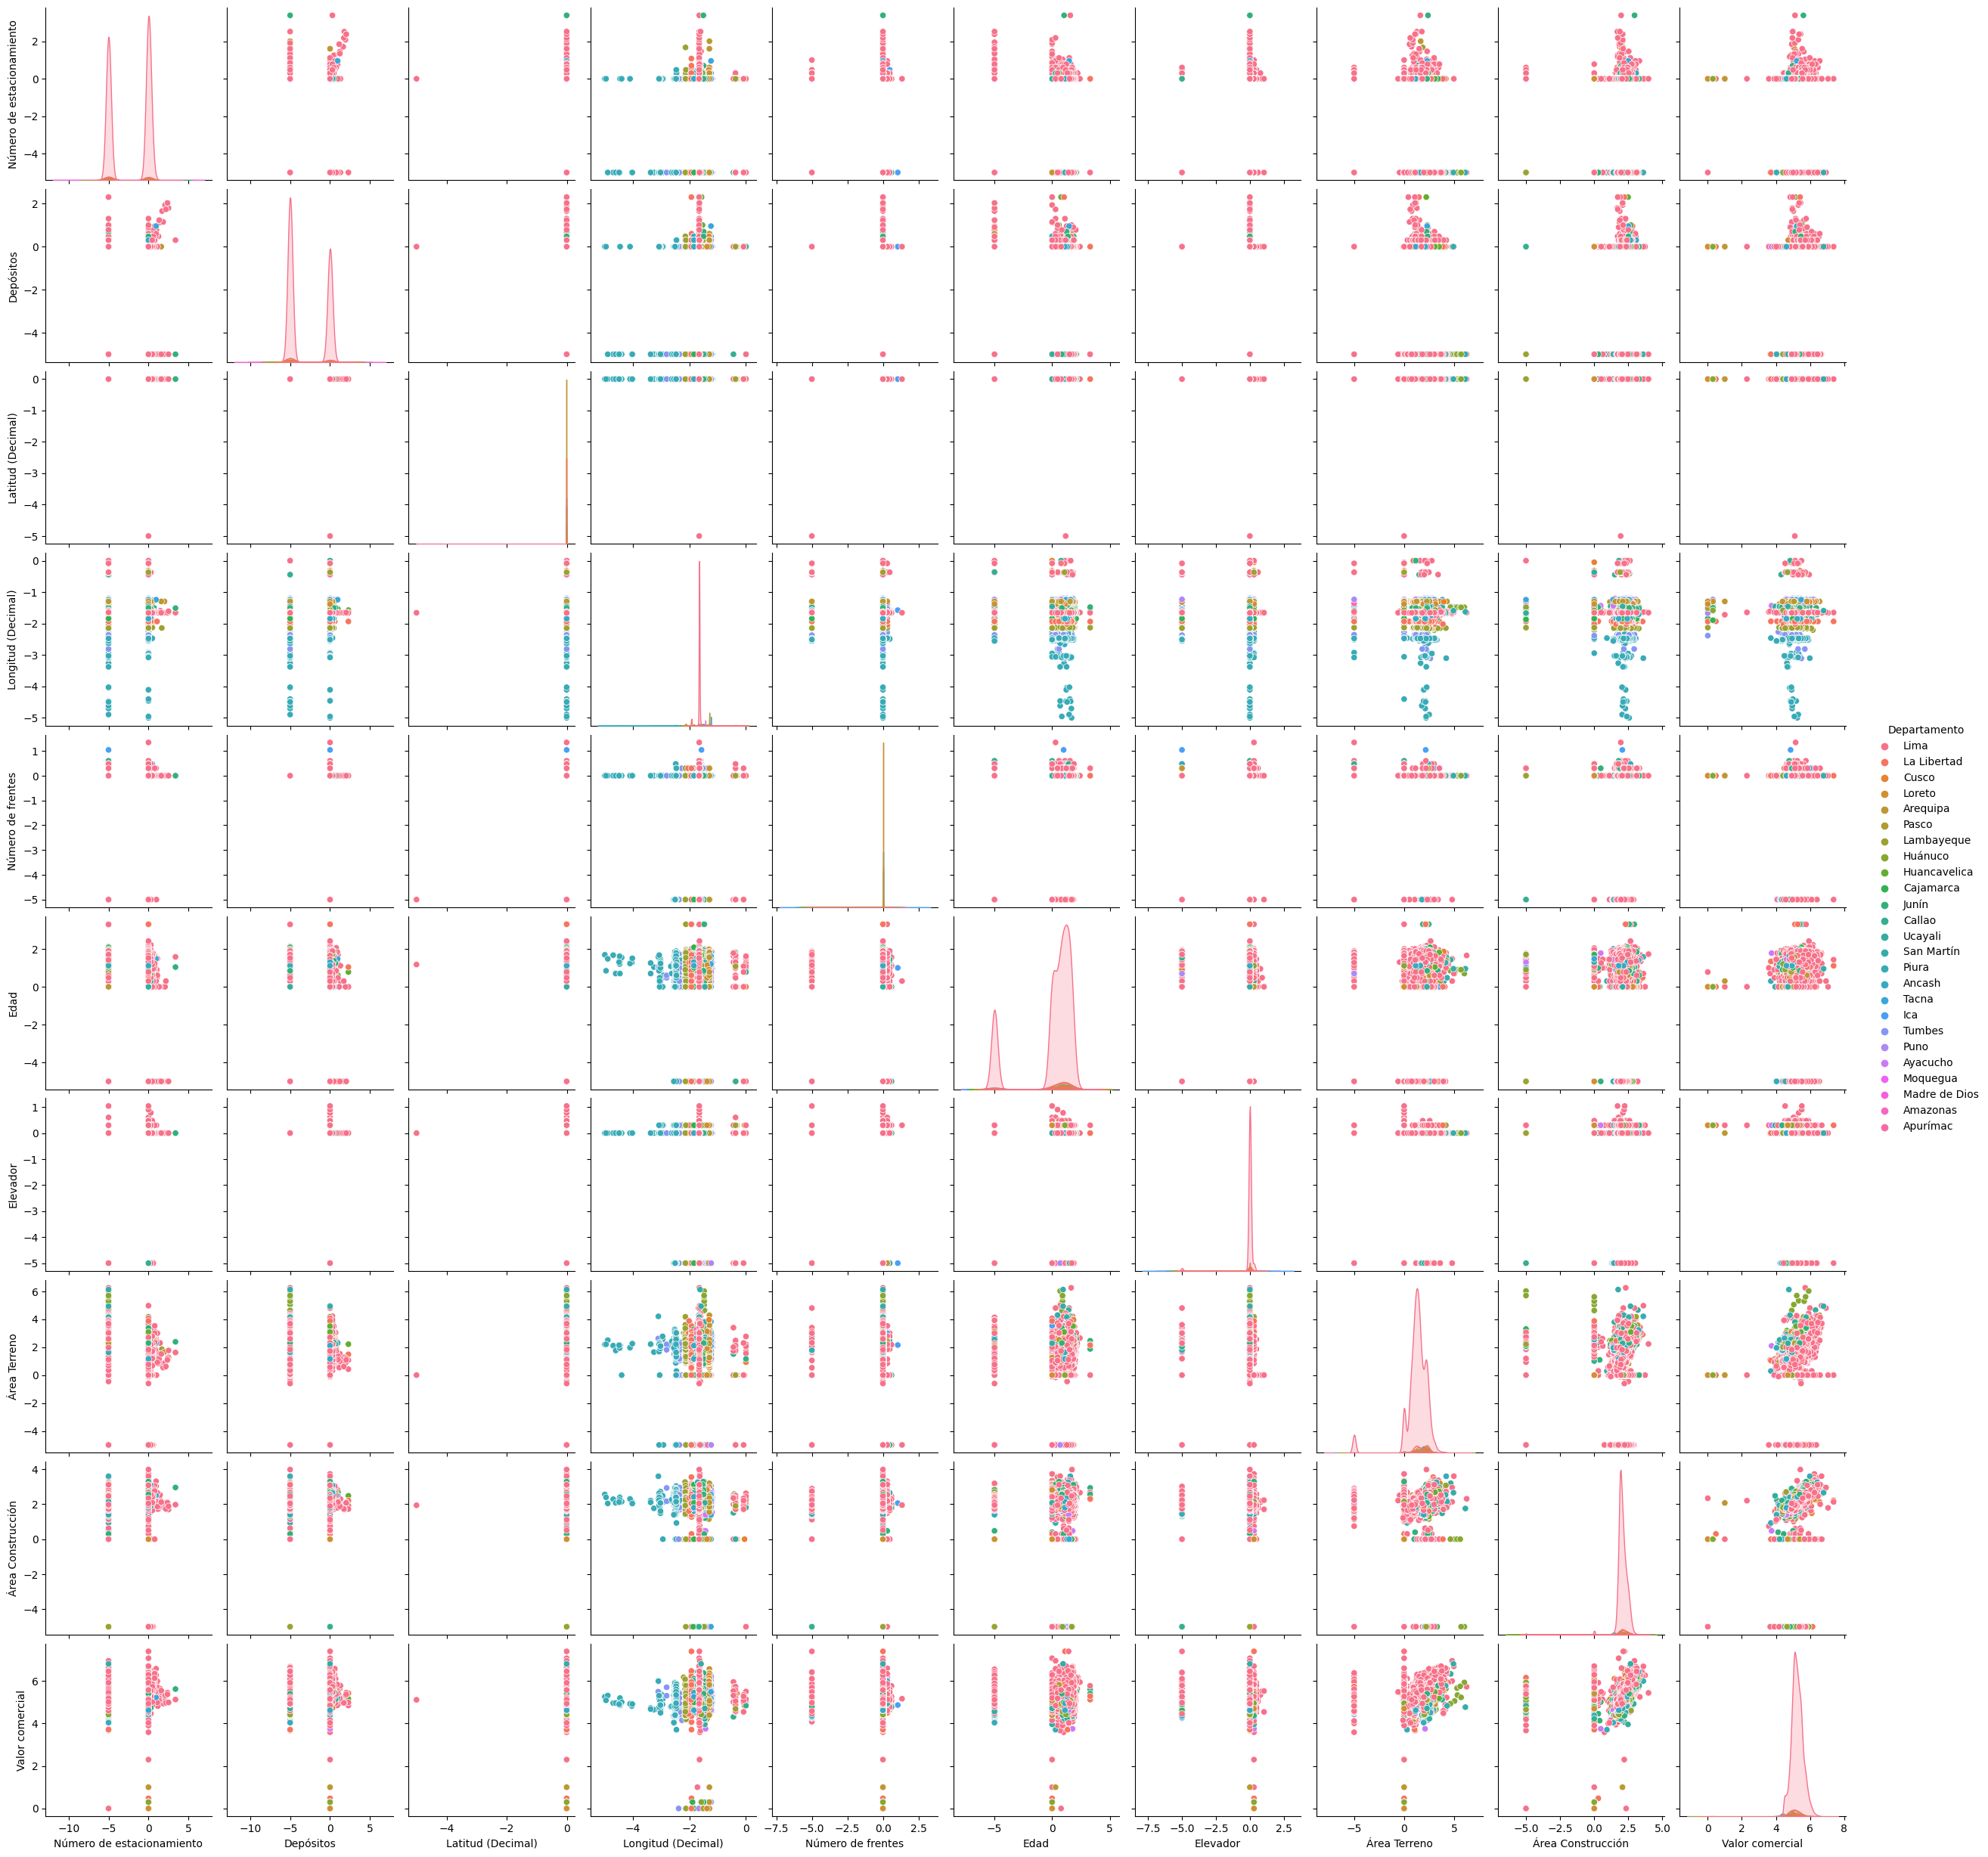

In [76]:
numerical_data_log.insert(0,'Departamento', dataset['Departamento'].to_numpy())

sns.pairplot(numerical_data_log, hue='Departamento')
plt.show()

/tmp/ipykernel_19575/722057007.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  linkage_data = linkage(numerical_data_log.corr().applymap(lambda x: np.abs(x)), method='single', metric='euclidean')


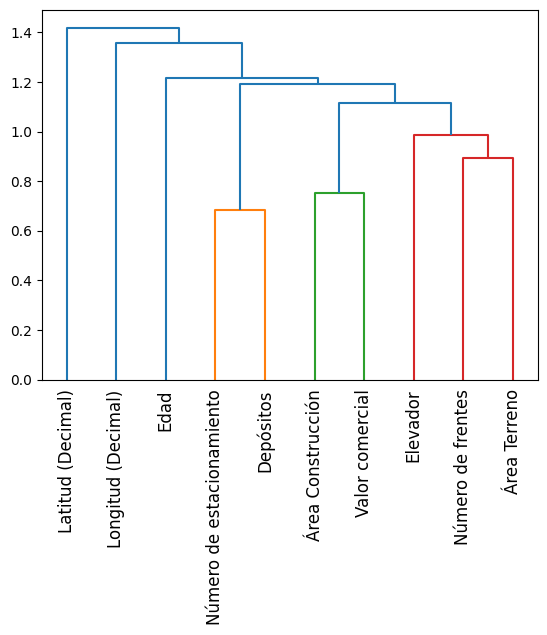

In [77]:
linkage_data = linkage(numerical_data_log.corr().applymap(lambda x: np.abs(x)), method='single', metric='euclidean')
dendrogram(linkage_data, labels=numerical_data.columns, leaf_rotation=90, count_sort=True)

plt.show()

## Serie de Tiempo de los precios de la base de datos



## Matriz de Correlacion de todos los datos

/tmp/ipykernel_19575/1359459431.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.corr()
/tmp/ipykernel_19575/1359459431.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset.corr(), vmin=-1, vmax=1, cmap= "vlag")


<AxesSubplot: >

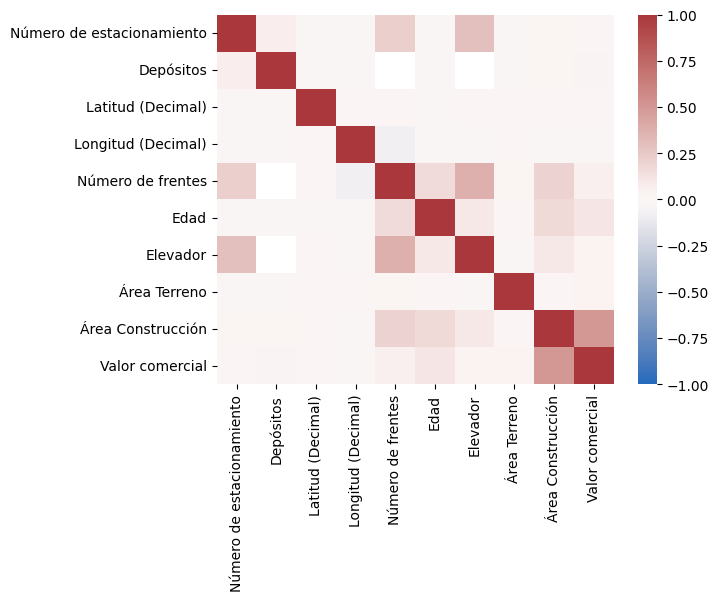

In [62]:
dataset.corr()

sns.heatmap(dataset.corr(), vmin=-1, vmax=1, cmap= "vlag")

## Observaciones

De primera mano, podemos observar que:

Variables mas correlacionadas con respecto al valor commercial son

    - Area de construcción
    - Edad
    - Area del Terreno
    - Numero de Frentes